In [ ]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import rcParams
import seaborn as sns
import re
folderpath = "/home/jsw/BI/Database/siglec-9/"

In [14]:
# barcode, feature, matrix 파일을 읽어서 AnnData 객체로 바꾼 후 adata_list에 저장.
import glob
import shutil
def read_10x_mtx_multiple(directory):
    # matrix, barcodes, features 파일 검색
    matrix_files = glob.glob(os.path.join(directory, '*matrix.mtx.gz'))
    barcode_files = glob.glob(os.path.join(directory, '*barcodes.tsv.gz'))
    feature_files = glob.glob(os.path.join(directory, '*features.tsv.gz'))
    feature_files += glob.glob(os.path.join(directory, '*genes.tsv.gz'))
    
    adata_list = []
    # print(matrix_files)
    
    for matrix_file in matrix_files:
        # 파일 이름에서 base_name (공통 이름) 추출
        base_name = os.path.basename(matrix_file).split('matrix')[0]
        
        # base_name 으로 barcodes, features (genes) 파일 찾기
        barcode_file = [bf for bf in barcode_files if base_name in bf]
        feature_file = [ff for ff in feature_files if base_name in ff]
        print(matrix_file, barcode_file, feature_file)
        
        if len(barcode_file) == 1 and len(feature_file) == 1:   # 만약 barcode, feature 파일이 하나씩 있는 경우
            matrix_dir = os.path.dirname(matrix_file)
            
            # 임시 디렉토리 생성 및 파일 복사
            temp_dir = os.path.join(directory, base_name + '_temp')
            os.makedirs(temp_dir, exist_ok=True)
            
            shutil.copy(matrix_file, os.path.join(temp_dir, 'matrix.mtx.gz'))
            shutil.copy(barcode_file[0], os.path.join(temp_dir, 'barcodes.tsv.gz'))
            
            if 'features' in feature_file[0]:   # features.tsv.gz 파일인 경우
                # shutil.copy(feature_file[0], os.path.join(temp_dir, 'features.tsv.gz'))
                features = pd.read_csv(feature_file[0], header = None, sep = '\t', compression = 'gzip')
                if features.shape[1] == 1: # gene name column만 있는 경우
                    features['gene_id'] = features[0]
                    features['feature_type'] = 'Gene Expression'
                    features = features[[0, 'gene_id', 'feature_type']]
                features.to_csv(os.path.join(temp_dir, 'features.tsv.gz'), header = False, index = False, sep = '\t', compression = 'gzip')
            else:   # genes.tsv.gz 파일인 경우 (type column이 없이 gene ID, gene name만 있는 경우)
                # genes.tsv.gz 파일을 features.tsv.gz 형식으로 변환
                genes = pd.read_csv(feature_file[0], header = None, sep = '\t', compression = 'gzip')
                genes['type'] = 'Gene Expression'
                genes.to_csv(os.path.join(temp_dir, 'features.tsv.gz'), header = False, index = False, sep = '\t', compression = 'gzip')
            
            # read data
            adata = sc.read_10x_mtx(
                path = temp_dir,
                var_names = 'gene_symbols',
                make_unique = True
            )
            adata.var_names_make_unique()   # gene 이름 중복 제거
            adata.obs['sample'] = base_name # sample 열 추가
            adata.obs['sample'] = adata.obs['sample'].apply(lambda x: re.search(r'_(.*?)_', x).group(1)) # 파일 이름에서 _와 _ 사이의 문자열 추출
            
            # 임시 디렉토리 및 파일 삭제
            shutil.rmtree(temp_dir)
            
            adata_list.append(adata)
        else:   # 파일이 없거나 여러개인 경우
            print(f"Could not find matching barcode of feature file for {base_name}")
            
    return adata_list

In [15]:
adata_list = read_10x_mtx_multiple(folderpath)

adata_list

/home/jsw/BI/Database/siglec-9/GSM7507520_Pt15_matrix.mtx.gz ['/home/jsw/BI/Database/siglec-9/GSM7507520_Pt15_barcodes.tsv.gz'] ['/home/jsw/BI/Database/siglec-9/GSM7507520_Pt15_features.tsv.gz']
/home/jsw/BI/Database/siglec-9/GSM7507515_Pt10_matrix.mtx.gz ['/home/jsw/BI/Database/siglec-9/GSM7507515_Pt10_barcodes.tsv.gz'] ['/home/jsw/BI/Database/siglec-9/GSM7507515_Pt10_features.tsv.gz']
/home/jsw/BI/Database/siglec-9/GSM7507510_Pt5_matrix.mtx.gz ['/home/jsw/BI/Database/siglec-9/GSM7507510_Pt5_barcodes.tsv.gz'] ['/home/jsw/BI/Database/siglec-9/GSM7507510_Pt5_features.tsv.gz']
/home/jsw/BI/Database/siglec-9/GSM7507518_Pt13_matrix.mtx.gz ['/home/jsw/BI/Database/siglec-9/GSM7507518_Pt13_barcodes.tsv.gz'] ['/home/jsw/BI/Database/siglec-9/GSM7507518_Pt13_features.tsv.gz']
/home/jsw/BI/Database/siglec-9/GSM7507522_Pt17_matrix.mtx.gz ['/home/jsw/BI/Database/siglec-9/GSM7507522_Pt17_barcodes.tsv.gz'] ['/home/jsw/BI/Database/siglec-9/GSM7507522_Pt17_features.tsv.gz']
/home/jsw/BI/Database/siglec

[AnnData object with n_obs × n_vars = 8553 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2606 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 7315 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 3064 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 8953 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 670 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2896 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1828 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 9738 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with

In [16]:
len(adata_list)

18

# Basic filtering

In [17]:
for adata in adata_list:
    sc.pp.filter_cells(adata, min_genes = 20)
adata_list

[AnnData object with n_obs × n_vars = 8553 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2606 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 7315 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 3064 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 8953 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 670 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2896 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1828 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 973

In [18]:
# list of ribosommal genes
# for mouse genes
# ribo_url = 'https://www.gsea-msigdb.org/gsea/msigdb/mouse/download_geneset.jsp?geneSetName=GOCC_RIBOSOME&fileType=gmt'
# ribo_genes = pd.read_table(ribo_url, sep = '\t', header = None).transpose().drop([0, 1])

# for human genes
ribo_url = 'http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt'
ribo_genes = pd.read_table(ribo_url, skiprows = 2, header = None)

del ribo_url

In [19]:
# Calculate QC metrics
for adata in adata_list:
    adata.var['mito'] = adata.var_names.str.startswith('MT-')   # 'mt-' for mouse, 'MT-' for human  # mitochondrial genes boolean
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)  # ribosomal genes boolean
    
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True, qc_vars=['mito', 'ribo'])    # calculate qc metrics

    # remove useless vars
    adata.obs.drop(columns=['total_counts_mito', 'total_counts_ribo'], inplace=True)
    adata.var.drop(columns=['mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'], inplace=True)

adata_list
del ribo_genes

In [20]:
# Filter the data
for i in range(len(adata_list)):
    cutoff_top = np.quantile(adata_list[i].obs.n_genes_by_counts.values, .95)
    adata_list[i] = adata_list[i][adata_list[i].obs.n_genes_by_counts < cutoff_top]
    
    cutoff_top = np.quantile(adata_list[i].obs.total_counts.values, .95)
    adata_list[i] = adata_list[i][adata_list[i].obs.total_counts < cutoff_top]
    
    cutoff_top = np.quantile(adata_list[i].obs.pct_counts_mito.values, .90)
    adata_list[i] = adata_list[i][adata_list[i].obs.pct_counts_mito < cutoff_top]

adata_list
del cutoff_top, i

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 4.0%
Estimated detectable doublet fraction = 36.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.2%
Elapsed time: 4.3 seconds
Processed adata 1/18 successfully.


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 4.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.0%
Elapsed time: 0.9 seconds
Processed adata 2/18 successfully.
Preprocessing...


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 8.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.5%
Elapsed time: 3.8 seconds
Processed adata 3/18 successfully.
Preprocessing...


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 3.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.1%
Elapsed time: 1.0 seconds
Processed adata 4/18 successfully.


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 18.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.6%
Elapsed time: 5.0 seconds
Processed adata 5/18 successfully.


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 12.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.6%
Elapsed time: 0.3 seconds
Processed adata 6/18 successfully.
Preprocessing...


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.63
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.0%
Elapsed time: 1.0 seconds
Processed adata 7/18 successfully.
Preprocessing...


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 0.8 seconds
Processed adata 8/18 successfully.


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 3.2%
Estimated detectable doublet fraction = 36.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.8%
Elapsed time: 5.2 seconds
Processed adata 9/18 successfully.


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 6.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.0%
Elapsed time: 0.5 seconds
Processed adata 10/18 successfully.


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 6.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.6%
Elapsed time: 0.9 seconds
Processed adata 11/18 successfully.
Preprocessing...


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 4.2 seconds
Processed adata 12/18 successfully.
Preprocessing...


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 8.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.6%
Elapsed time: 0.5 seconds
Processed adata 13/18 successfully.


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 2.4%
Estimated detectable doublet fraction = 52.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.6%
Elapsed time: 3.5 seconds
Processed adata 14/18 successfully.


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 3.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.4%
Elapsed time: 1.9 seconds
Processed adata 15/18 successfully.


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 7.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.5%
Elapsed time: 0.8 seconds
Processed adata 16/18 successfully.
Preprocessing...
Simulating doublets...


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 47.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.2%
Elapsed time: 0.4 seconds
Processed adata 17/18 successfully.
Preprocessing...


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.63
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.1%
Elapsed time: 1.0 seconds
Processed adata 18/18 successfully.


/tmp/ipykernel_86454/3684440307.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


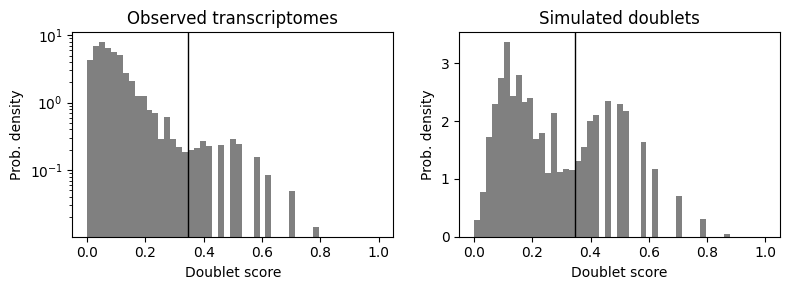

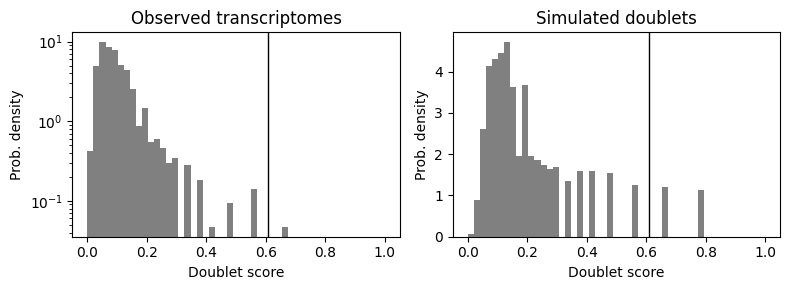

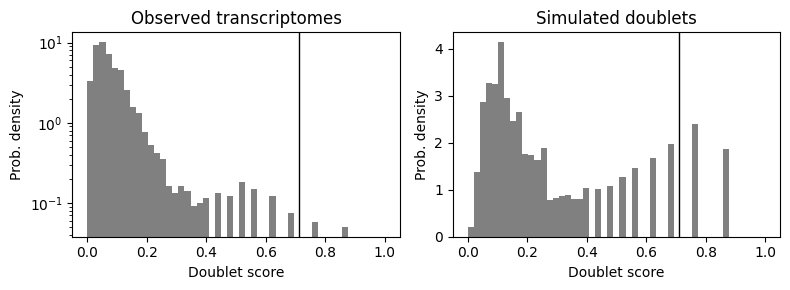

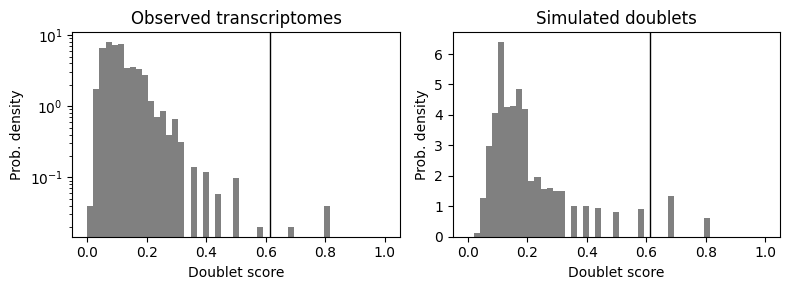

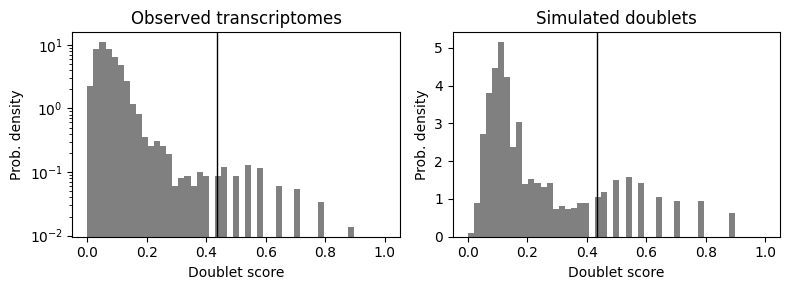

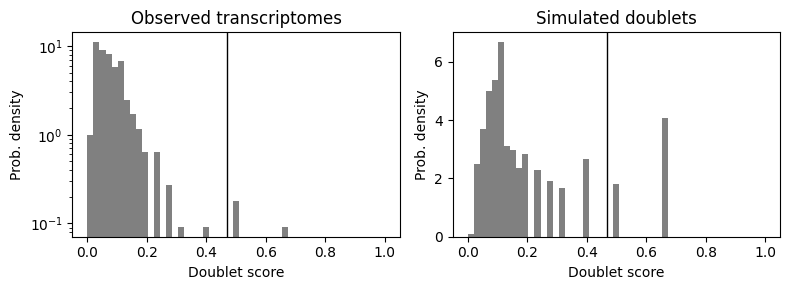

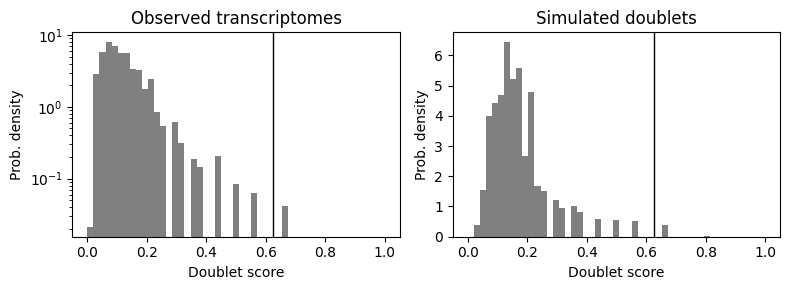

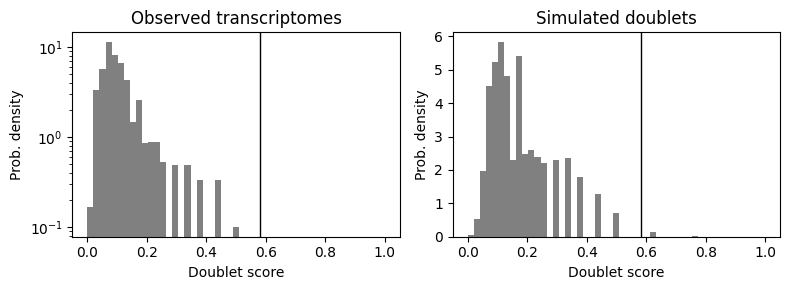

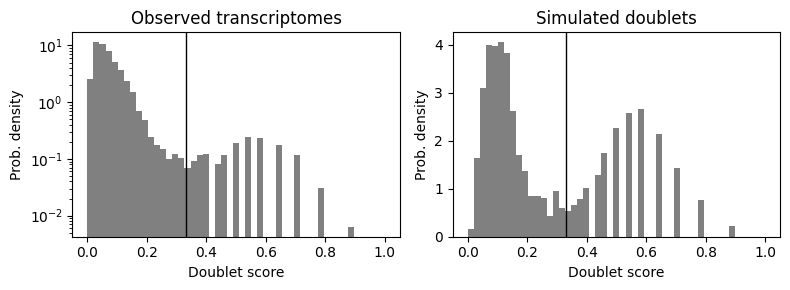

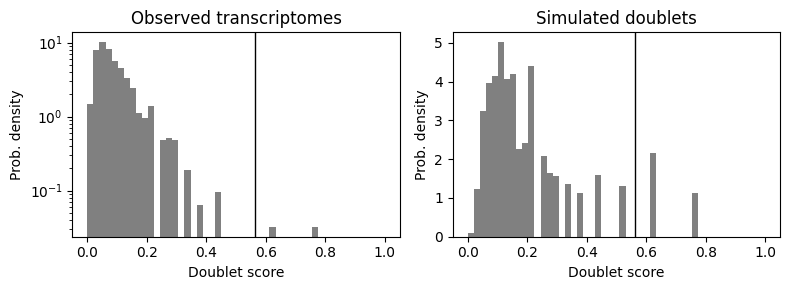

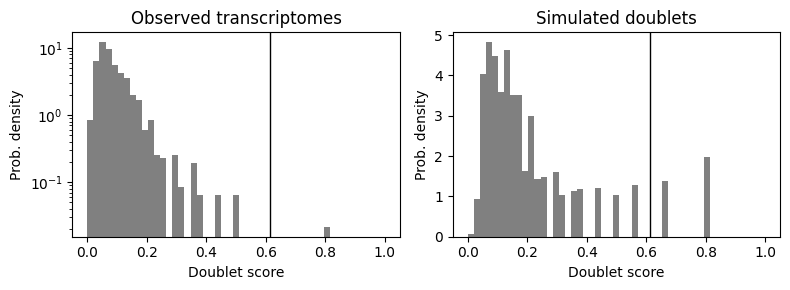

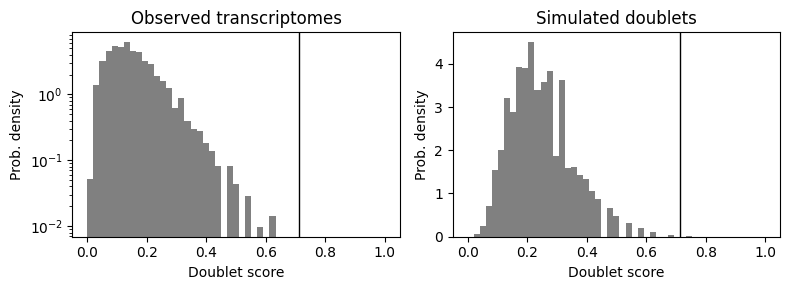

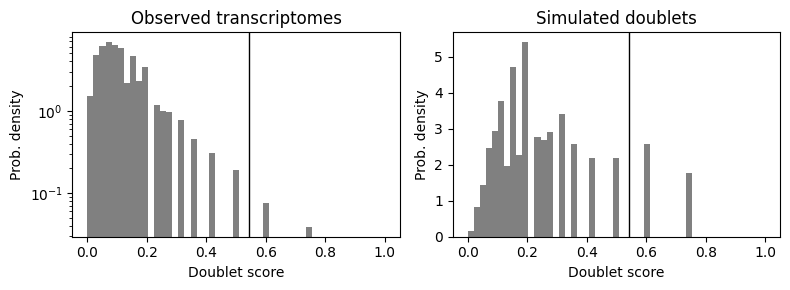

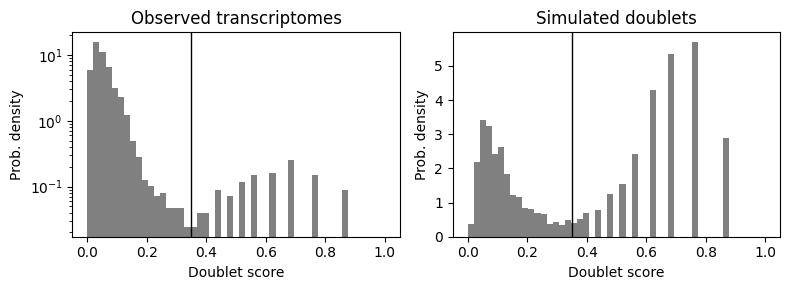

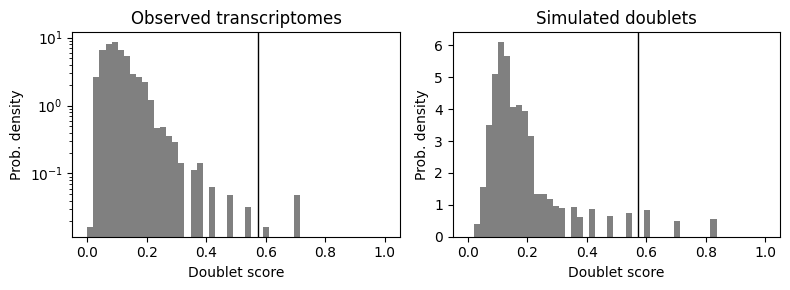

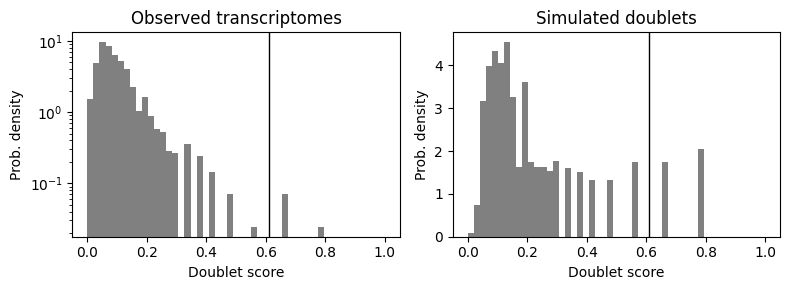

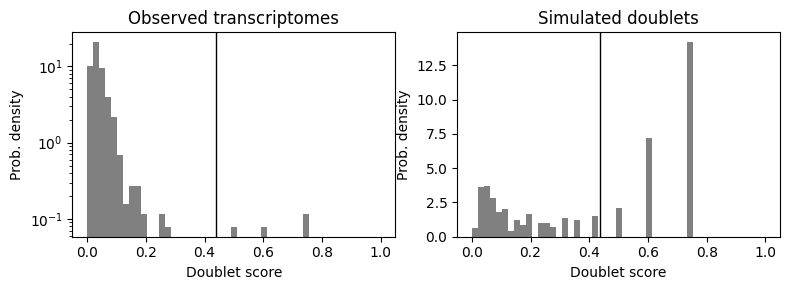

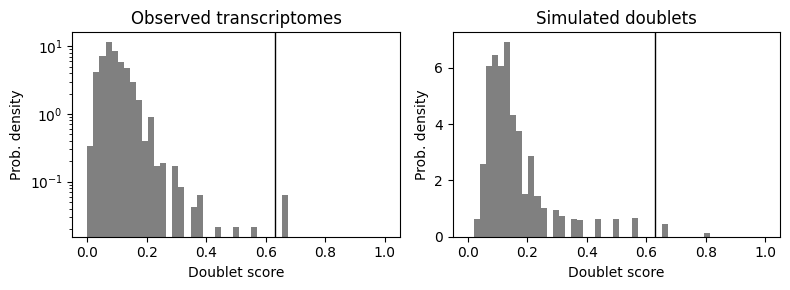

In [21]:
import scrublet as scr
for i, adata in enumerate(adata_list):
    try:
        # Scrublet 객체 생성
        scrub = scr.Scrublet(adata.X)
        
        doublet_scores, predicted_doublets = scrub.scrub_doublets()
        
        adata.obs['doublet_scores'] = doublet_scores
        adata.obs['predicted_doublets'] = predicted_doublets
        
        print(f"Processed adata {i + 1}/{len(adata_list)} successfully.")
        scrub.plot_histogram()
    except Exception as e:
        print(f"Error in processing adata {i + 1}/{len(adata_list)}: {e}")
        # adata.obs의 doublet_scores와 predicted_doublets에 모두 NA를 설정
        adata.obs['doublet_scores'] = pd.Series([np.nan] * adata.shape[0])
        adata.obs['predicted_doublets'] = pd.Series([np.nan] * adata.shape[0])
        continue

del scrub, doublet_scores, predicted_doublets

In [22]:
adata_list

[AnnData object with n_obs × n_vars = 6946 × 33694
     obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2115 × 33694
     obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 5940 × 33694
     obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2487 × 33694
     obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 7270 × 33694
     obs:

In [23]:
# remove doublets
for i in range(len(adata_list)):
    try:
        adata_list[i] = adata_list[i][~adata_list[i].obs['predicted_doublets'], :]
    except Exception as e:
        continue

adata_list

[View of AnnData object with n_obs × n_vars = 6666 × 33694
     obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets'
     var: 'gene_ids', 'feature_types',
 View of AnnData object with n_obs × n_vars = 2113 × 33694
     obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets'
     var: 'gene_ids', 'feature_types',
 View of AnnData object with n_obs × n_vars = 5927 × 33694
     obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets'
     var: 'gene_ids', 'feature_types',
 View of AnnData object with n_obs × n_vars = 2484 × 33694
     obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets'
     var: 'gene_ids', 'feature_types',
 View of AnnData object with

In [24]:
# 세포가 1개 이상인 샘플만 남기기
adata_list = [adata for adata in adata_list if adata.n_obs > 0]
len(adata_list)

18

# Merge the data

In [25]:
adata = sc.concat(adata_list, join = 'outer', label = 'sample', keys = [adata.obs['sample'].unique()[0] for adata in adata_list])
adata.obs.drop(columns=['n_genes_by_counts'], inplace=True)

adata.obs_names_make_unique()

# filter out genes expressed in less than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# preserve the raw data
adata.layers['counts'] = adata.X.copy() # scVI use this data

/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [27]:
adata.write_h5ad(folderpath + 'adata_preprocessed.h5ad')

# Annotation

In [1]:
import scanpy as sc
import harmonypy as hm
import matplotlib.pyplot as plt
from matplotlib import rcParams
folderpath = "/home/jsw/BI/Database/siglec-9/"

In [12]:
adata = sc.read_h5ad(folderpath + 'adata_preprocessed.h5ad')

In [13]:
# 데이터 전처리 (필요시 실행)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, batch_key='sample')
# adata = adata[:, adata.var['highly_variable']]

# PCA 수행
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps = 50)

In [14]:
import bbknn
bbknn.bbknn(adata, batch_key = 'sample', neighbors_within_batch = 10, n_pcs = 30)

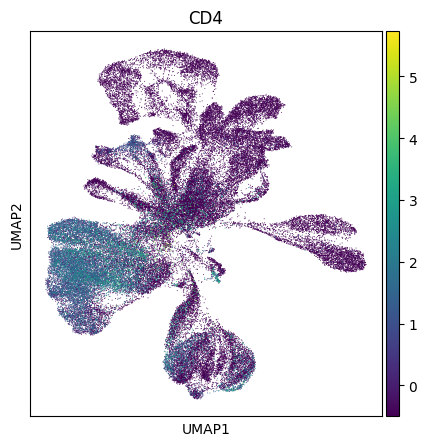

In [16]:
# UMAP 시각화
# sc.pp.neighbors(adata, n_neighbors=8, n_pcs=20)
sc.tl.umap(adata)
fig = sc.pl.umap(adata, color='CD4', return_fig=True)
fig.set_size_inches(5, 5)
plt.show()

2024-11-22 17:21:40,416 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-22 17:21:48,521 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-22 17:21:48,703 - harmonypy - INFO - Iteration 1 of 30
2024-11-22 17:21:59,568 - harmonypy - INFO - Iteration 2 of 30
2024-11-22 17:22:12,785 - harmonypy - INFO - Iteration 3 of 30
2024-11-22 17:22:24,793 - harmonypy - INFO - Iteration 4 of 30
2024-11-22 17:22:36,523 - harmonypy - INFO - Iteration 5 of 30
2024-11-22 17:22:48,493 - harmonypy - INFO - Iteration 6 of 30
2024-11-22 17:22:57,832 - harmonypy - INFO - Iteration 7 of 30
2024-11-22 17:23:09,704 - harmonypy - INFO - Iteration 8 of 30
2024-11-22 17:23:21,616 - harmonypy - INFO - Iteration 9 of 30
2024-11-22 17:23:33,629 - harmonypy - INFO - Iteration 10 of 30
2024-11-22 17:23:42,880 - harmonypy - INFO - Iteration 11 of 30
2024-11-22 17:23:48,302 - harmonypy - INFO - Iteration 12 of 30
2024-11-22 17:23:53,286 - harmonypy - INFO - Iteration 13 of

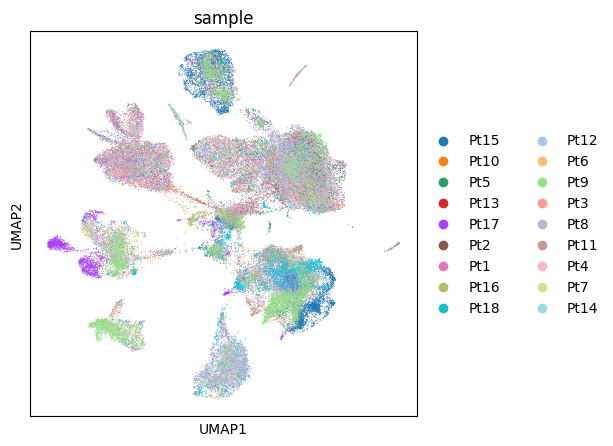

In [ ]:
# # Harmony로 배치 보정
# ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs, 'sample', max_iter_harmony = 30)
# adata.obsm['X_pca_harmony'] = ho.Z_corr.T  # Harmony 보정된 PCA 결과를 저장

# # UMAP 시각화
# sc.pp.neighbors(adata, use_rep='X_pca_harmony')
# sc.tl.umap(adata)
# fig = sc.pl.umap(adata, color='sample', return_fig=True)
# fig.set_size_inches(5, 5)
# plt.show()

In [17]:
# leiden clustering
sc.tl.leiden(adata, resolution=0.5)
fig = sc.pl.umap(adata, color='leiden', return_fig=True)
fig.set_size_inches(5, 5)
plt.show()

KeyboardInterrupt: 

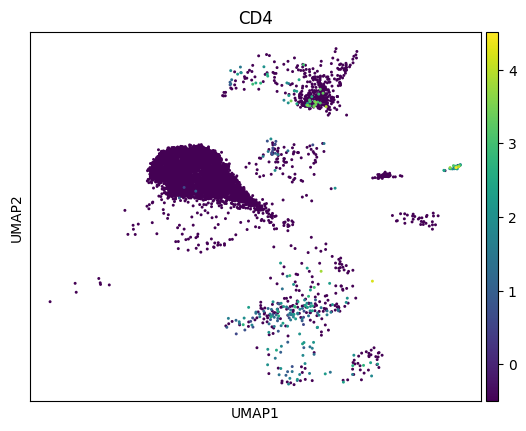

In [7]:
# adata.obs['sample']이 Pt5인 세포만 선택

adata_subset = adata[adata.obs['sample'] == 'Pt15', :]
sc.pl.umap(
    adata_subset,
    color = 'CD4'
)

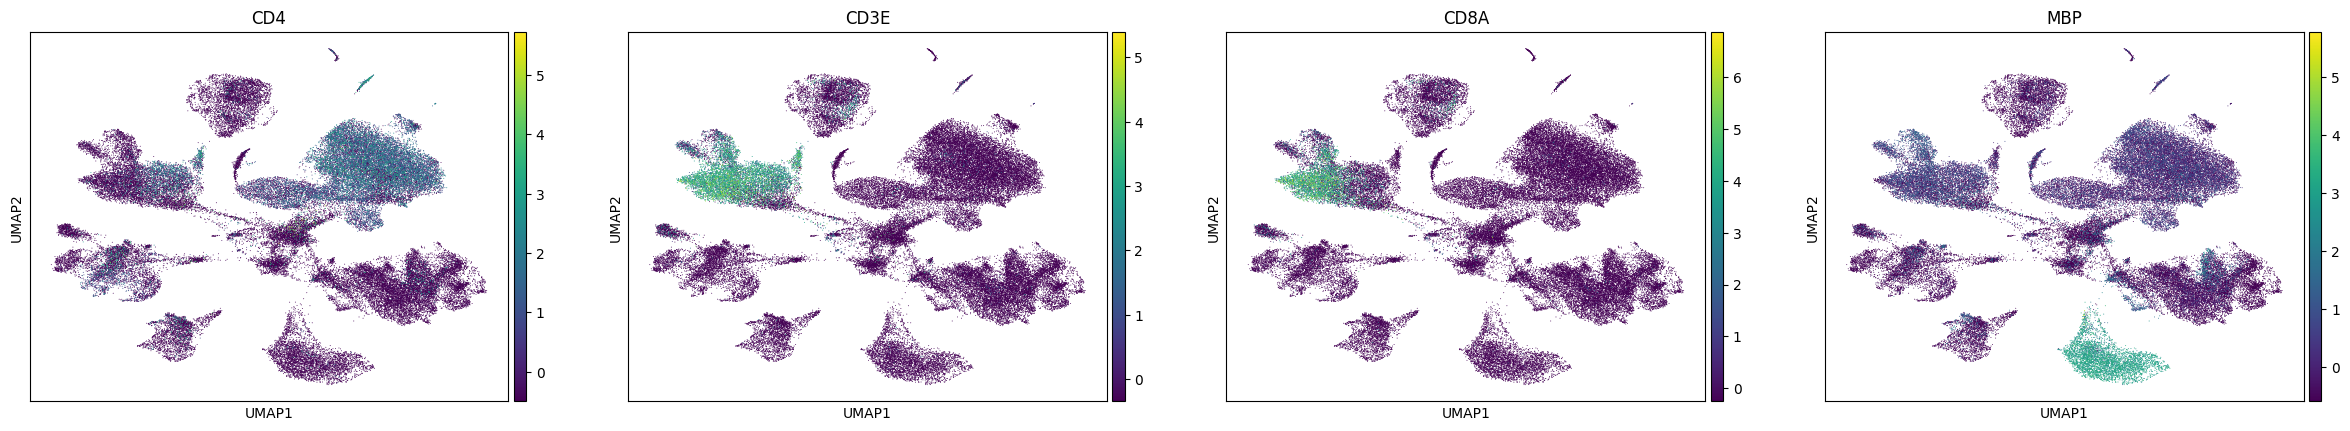

In [40]:
sc.pl.umap(
    adata,
    color = ['CD4', 'CD3E', 'CD8A', 'MBP']
)